In [1]:
!curl -O https://download.pytorch.org/tutorial/data.zip; unzip data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2814k  100 2814k    0     0  1362k      0  0:00:02  0:00:02 --:--:-- 1362k
Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating

In [1]:
# %pip install unidecode

  Using cached Unidecode-1.3.8-py3-none-any.whl.metadata (13 kB)
Using cached Unidecode-1.3.8-py3-none-any.whl (235 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import random
from string import ascii_letters

import torch
from torch import nn
import torch.nn.functional as F
from unidecode import unidecode

In [ ]:
_ = torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
data_dir = "./data/names"

lang2label = {
    file_name.split(".")[0]: torch.tensor([i], dtype=torch.long)
    for i, file_name in enumerate(os.listdir(data_dir))
}

In [ ]:
lang2label

{'Czech': tensor([0]),
 'English': tensor([1]),
 'Russian': tensor([2]),
 'Scottish': tensor([3]),
 'Chinese': tensor([4]),
 'French': tensor([5]),
 'Spanish': tensor([6]),
 'Italian': tensor([7]),
 'Greek': tensor([8]),
 'Dutch': tensor([9]),
 'Korean': tensor([10]),
 'Polish': tensor([11]),
 'Irish': tensor([12]),
 'Japanese': tensor([13]),
 'German': tensor([14]),
 'Arabic': tensor([15]),
 'Vietnamese': tensor([16]),
 'Portuguese': tensor([17])}

In [ ]:
lang2label['Russian'].shape

torch.Size([1])

In [ ]:
num_langs = len(lang2label) # общее количество языков
num_langs

18

In [ ]:
unidecode("Привет") # Транслитерация

'Privet'

In [ ]:
char2idx = {letter: i for i, letter in enumerate(ascii_letters + " .,:;-'")}
num_letters = len(char2idx); num_letters

59

In [ ]:
char2idx

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 'A': 26,
 'B': 27,
 'C': 28,
 'D': 29,
 'E': 30,
 'F': 31,
 'G': 32,
 'H': 33,
 'I': 34,
 'J': 35,
 'K': 36,
 'L': 37,
 'M': 38,
 'N': 39,
 'O': 40,
 'P': 41,
 'Q': 42,
 'R': 43,
 'S': 44,
 'T': 45,
 'U': 46,
 'V': 47,
 'W': 48,
 'X': 49,
 'Y': 50,
 'Z': 51,
 ' ': 52,
 '.': 53,
 ',': 54,
 ':': 55,
 ';': 56,
 '-': 57,
 "'": 58}

In [ ]:
def name2tensor(name):
    tensor = torch.zeros(len(name), 1, num_letters)
    for i, char in enumerate(name):
        tensor[i][0][char2idx[char]] = 1
    return tensor

В PyTorch слои RNN ожидают, что входной тензор будет иметь размер (seq_len, batch_size, input_size)

In [ ]:
name2tensor("abc")

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]]])

In [ ]:
name2tensor("abc").shape

torch.Size([3, 1, 59])

In [ ]:
tensor_names = []
target_langs = []

for file in os.listdir(data_dir):
    with open(os.path.join(data_dir, file)) as f:
        lang = file.split(".")[0]
        names = [unidecode(line.rstrip()) for line in f]
        for name in names:
            try:
                tensor_names.append(name2tensor(name))
                target_langs.append(lang2label[lang])
            except KeyError:
                pass

In [ ]:
from sklearn.model_selection import train_test_split
test_size=0.4
train_idx, test_idx = train_test_split(
    range(len(target_langs)),
    test_size=test_size,
    shuffle=True,
    stratify=target_langs
)

train_dataset = [
    (tensor_names[i], target_langs[i])
    for i in train_idx
]

test_dataset = [
    (tensor_names[i], target_langs[i])
    for i in test_idx
]

In [ ]:
print(f"Train: {len(train_dataset)}")
print(f"Test: {len(test_dataset)}")

Train: 12042
Test: 8028


Наша RNN принимает односимвольное тензорное представление в качестве входных данных и выдает некоторое предсказание и скрытое состояние, которые можно использовать на следующей итерации.

In [ ]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyRNN, self).__init__()
        self.hidden_size = hidden_size
        self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.in2output = nn.Linear(input_size + hidden_size, output_size)

    def forward(self, x, hidden_state):
        combined = torch.cat((x, hidden_state), 1)
        hidden = torch.sigmoid(self.in2hidden(combined))
        output = self.in2output(combined)
        return output, hidden

    def init_hidden(self):
        return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))

In [ ]:
hidden_size = 32
learning_rate = 0.01

model = MyRNN(num_letters, hidden_size, num_langs)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
num_epochs = 2
print_interval = 1000

for epoch in range(num_epochs):
    random.shuffle(train_dataset)
    for i, (name, label) in enumerate(train_dataset):
        hidden_state = model.init_hidden()
        for char in name:
            output, hidden_state = model(char, hidden_state)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        if (i + 1) % print_interval == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Step [{i + 1}/{len(train_dataset)}], "
                f"Loss: {loss.item():.4f}"
            )

Epoch [1/2], Step [1000/12042], Loss: 0.4249
Epoch [1/2], Step [2000/12042], Loss: 0.0000
Epoch [1/2], Step [3000/12042], Loss: 0.0079
Epoch [1/2], Step [4000/12042], Loss: 2.5014
Epoch [1/2], Step [5000/12042], Loss: 2.3866
Epoch [1/2], Step [6000/12042], Loss: 0.0116
Epoch [1/2], Step [7000/12042], Loss: 0.0042
Epoch [1/2], Step [8000/12042], Loss: 0.0000
Epoch [1/2], Step [9000/12042], Loss: 1.6738
Epoch [1/2], Step [10000/12042], Loss: 0.1447
Epoch [1/2], Step [11000/12042], Loss: 1.4497
Epoch [1/2], Step [12000/12042], Loss: 3.9547
Epoch [2/2], Step [1000/12042], Loss: 0.0138
Epoch [2/2], Step [2000/12042], Loss: 0.0005
Epoch [2/2], Step [3000/12042], Loss: 1.6070
Epoch [2/2], Step [4000/12042], Loss: 0.0253
Epoch [2/2], Step [5000/12042], Loss: 0.0000
Epoch [2/2], Step [6000/12042], Loss: 0.0032
Epoch [2/2], Step [7000/12042], Loss: 1.1969
Epoch [2/2], Step [8000/12042], Loss: 0.0049
Epoch [2/2], Step [9000/12042], Loss: 3.2298
Epoch [2/2], Step [10000/12042], Loss: 0.6994
Epoch 

In [ ]:
num_correct = 0
num_samples = len(test_dataset)

model.eval()

with torch.no_grad():
    for name, label in test_dataset:
        hidden_state = model.init_hidden()
        for char in name:
            output, hidden_state = model(char, hidden_state)
        _, pred = torch.max(output, dim=1)
        num_correct += bool(pred == label)

print(f"Accuracy: {num_correct / num_samples * 100:.4f}%")

Accuracy: 74.3024%


Агент Ащьф Лштшфум в фильме «Идентификация Борна», 2002

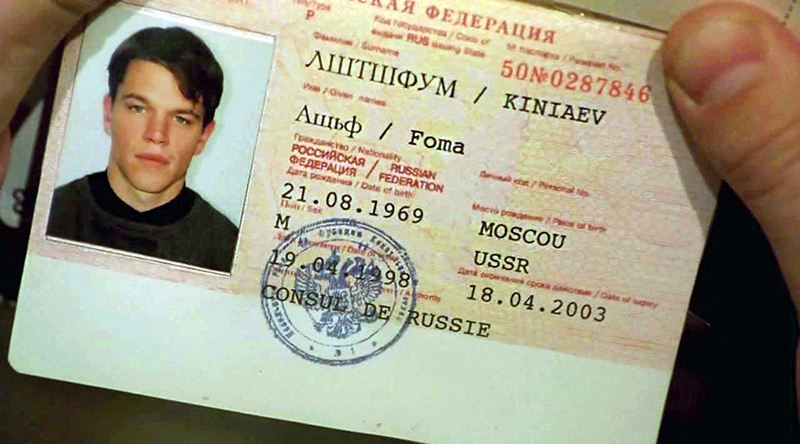

In [ ]:
label2lang = {label.item(): lang for lang, label in lang2label.items()}

def myrnn_predict(name):
    model.eval()
    tensor_name = name2tensor(name)
    with torch.no_grad():
        hidden_state = model.init_hidden()
        for char in tensor_name:
            output, hidden_state = model(char, hidden_state)
        _, pred = torch.max(output, dim=1)
    model.train()
    return label2lang[pred.item()]

In [ ]:
myrnn_predict("Kiniaev")

'Russian'

In [ ]:
myrnn_predict("Biden")

'English'

In [ ]:
myrnn_predict("Poniakowski")

'Russian'

In [ ]:
myrnn_predict("Rokossowski")


'Russian'

In [ ]:
unidecode("Си Цзиньпинь")

"Si Tszin'pin'"

In [ ]:
myrnn_predict(unidecode("Си"))

'Vietnamese'

# PyTorch GRU

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, num_layers, hidden_size):
        super(GRUModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(
            input_size=num_letters,
            hidden_size=hidden_size,
            num_layers=num_layers,
        )
        self.fc = nn.Linear(hidden_size, num_langs)

    def forward(self, x):
        hidden_state = self.init_hidden()
        output, hidden_state = self.gru(x, hidden_state)
        output = self.fc(output[-1])
        return output

    def init_hidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size).to(device)

In [ ]:
model = GRUModel(num_layers=2, hidden_size=hidden_size)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    random.shuffle(train_dataset)
    for i, (name, label) in enumerate(train_dataset):
        output = model(name)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % print_interval == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Step [{i + 1}/{len(train_dataset)}], "
                f"Loss: {loss.item():.4f}"
            )

Epoch [1/2], Step [1000/12042], Loss: 0.4553
Epoch [1/2], Step [2000/12042], Loss: 0.0201
Epoch [1/2], Step [3000/12042], Loss: 0.0395
Epoch [1/2], Step [4000/12042], Loss: 0.0067
Epoch [1/2], Step [5000/12042], Loss: 5.0964
Epoch [1/2], Step [6000/12042], Loss: 0.0880
Epoch [1/2], Step [7000/12042], Loss: 1.6603
Epoch [1/2], Step [8000/12042], Loss: 1.9314
Epoch [1/2], Step [9000/12042], Loss: 0.2197
Epoch [1/2], Step [10000/12042], Loss: 0.0049
Epoch [1/2], Step [11000/12042], Loss: 0.0094
Epoch [1/2], Step [12000/12042], Loss: 1.3004
Epoch [2/2], Step [1000/12042], Loss: 0.0015
Epoch [2/2], Step [2000/12042], Loss: 0.7299
Epoch [2/2], Step [3000/12042], Loss: 0.0018
Epoch [2/2], Step [4000/12042], Loss: 0.0102
Epoch [2/2], Step [5000/12042], Loss: 0.0005
Epoch [2/2], Step [6000/12042], Loss: 2.8921
Epoch [2/2], Step [7000/12042], Loss: 0.0848
Epoch [2/2], Step [8000/12042], Loss: 0.1694
Epoch [2/2], Step [9000/12042], Loss: 10.4678
Epoch [2/2], Step [10000/12042], Loss: 2.9150
Epoch

Потери высоки, когда предсказания модели уверенны, но неверны, и низки, когда предсказания модели соответствуют истинным меткам.

In [ ]:
num_correct = 0

model.eval()

with torch.no_grad():
    for name, label in test_dataset:
        output = model(name)
        _, pred = torch.max(output, dim=1)
        num_correct += bool(pred == label)

print(f"Accuracy: {num_correct / num_samples * 100:.4f}%")

Accuracy: 73.0693%


In [ ]:
def pytorch_predict(name):
    model.eval()
    tensor_name = name2tensor(name)
    with torch.no_grad():
        output = model(tensor_name)
        _, pred = torch.max(output, dim=1)
    model.train()
    return label2lang[pred.item()]

In [ ]:
pytorch_predict("Kiniaev")

'Russian'

In [ ]:
pytorch_predict("Biden")

'English'

https://jaketae.github.io/study/pytorch-rnn/